In [1]:
import pickle
import IPython.display as ipd
# feature extractoring and preprocessing data
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import signal
import noisereduce as nr
#Reports
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
data = pd.read_csv('./extracted_data.csv')
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()

,label,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,de_mfcc11,de_mfcc12,de_mfcc13,de_mfcc14,de_mfcc15,de_mfcc16,de_mfcc17,de_mfcc18,de_mfcc19,de_mfcc20
0,amecro,0.338716,0.034224,3616.920896,1966.074947,5831.529003,0.284085,-300.704651,-73.681175,-152.796417,...,-2.649461,3.687365,-3.583898,-1.690314,-2.579840,5.844545,-0.570906,1.842792,-6.125224,2.682204
1,amecro,0.606191,0.029051,2733.326161,2403.171895,5491.761647,0.171714,-289.052277,69.980736,-41.882755,...,-0.980518,1.679347,0.567278,1.058613,-5.341579,2.657883,0.366914,0.601444,-0.815928,1.959110
2,amecro,0.402761,0.076397,3645.575802,2173.824225,6076.584359,0.294855,-234.259277,-1.378142,-78.330360,...,-6.909959,3.638154,-0.954869,-1.682335,1.721543,0.476318,-1.213779,0.303300,-0.214653,1.033576
3,amecro,0.514074,0.021601,1988.833265,2266.835906,4205.494756,0.087000,-392.110748,92.414574,-31.003239,...,3.098013,-3.602407,3.895024,-3.446658,-0.231466,0.640920,0.918258,1.069209,-2.228328,0.905272
4,amecro,0.589420,0.056681,2002.241988,2366.313228,4432.136133,0.095752,-152.192566,119.386864,-4.404914,...,3.069260,2.077627,-3.567248,-1.038863,-0.406278,2.802787,-1.607536,2.183332,-2.002364,-0.568432


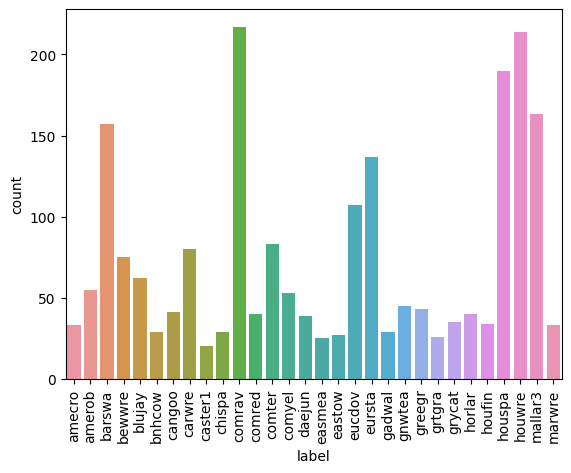

In [137]:
import seaborn as sns
ax = sns.countplot(x=data['label'])
ax.tick_params(axis='x', rotation=90)

In [3]:
bird_list = data.iloc[:, :1]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(bird_list)

In [4]:
try:
    data.insert(1, 'encoded_label', encoded_labels)
except:
    pass

In [5]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(np.array(data.iloc[:, 2:], dtype = float)), columns = data.columns[2:])

In [6]:
y = data['label']

In [7]:
model_list = ['Logisitic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']

In [8]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate

In [9]:
def run_pipeline(data, name=None):
    pipe_encoder = LabelEncoder()
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(np.array(data.iloc[:, 2:], dtype = float)), columns = data.columns[2:])
    y = data['label']
    encoded_labels = pipe_encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
    model_pipeline = []
    model_pipeline.append(SGDClassifier())
    model_pipeline.append(SVC(random_state=30))
    model_pipeline.append(KNeighborsClassifier(n_neighbors=30))
    model_pipeline.append(DecisionTreeClassifier(random_state=30))
    model_pipeline.append(RandomForestClassifier(random_state=30))
    model_pipeline.append(GaussianNB())
    # model_pipeline.append(xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax'))
    # model_list = ['Logisitic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
    classes = list(pipe_encoder.classes_)
    classes.append('macro')
    classes.append('accuracy')
    classes.append('fit_time')
    f1_scores = []
    cm_list = []

    for model in model_pipeline:
        model.fit(X_train, y_train)
        if name:
            pickle.dump(model, file = open('./models_cross/'+name+'_'+type(model).__name__+'.pkl', 'wb'))
        test_class_pred = model.predict(X_test)
        cm_list.append(confusion_matrix(y_test, test_class_pred))
        f1 = f1_score(y_test, test_class_pred, average=None)
        f1 = f1.tolist()
        scores = cross_validate(model, X=X_train.append(X_test), y=y_train.append(y_test), scoring=['accuracy', 'f1_macro'], return_train_score=True)
        f1.append(np.mean(scores['test_f1_macro']))
        f1.append(np.mean(scores['test_accuracy']))
        f1.append(np.mean(scores['fit_time']))
        f1_scores.append(f1)
    # print(len(f1_scores[0]))
    # print(len(classes))
    # f1_result_df = pd.DataFrame({'Classes': classes, 'KNN': f1_scores[0]})
    # f1_result_df = pd.DataFrame({'Classes': classes, 'SVM': f1_scores[0], 'KNN': f1_scores[1], 'Decision Tree': f1_scores[2], 'Random Forest': f1_scores[3], 'Naive Bayes': f1_scores[4]})
    f1_result_df = pd.DataFrame({'Classes': classes, 'SGD': f1_scores[0], 'SVM': f1_scores[1], 'KNN': f1_scores[2], 'Decision Tree': f1_scores[3], 'Random Forest': f1_scores[4], 'Naive Bayes': f1_scores[5]})
    return f1_result_df, cm_list, model_pipeline

In [10]:
f1, cm, trained_models = run_pipeline(data, name = '30_class')
f1

,Classes,SGD,SVM,KNN,Decision Tree,Random Forest,Naive Bayes
0,amecro,0.181818,0.000000,0.000000,0.200000,0.000000,0.000000
1,amerob,0.000000,0.000000,0.000000,0.000000,0.235294,0.000000
2,barswa,0.183908,0.271186,0.298507,0.172414,0.385965,0.054054
3,bewwre,0.100000,0.000000,0.000000,0.102564,0.200000,0.000000
4,blujay,0.066667,0.470588,0.125000,0.000000,0.133333,0.235294
5,bnhcow,0.181818,0.000000,0.000000,0.000000,0.000000,0.173913
6,cangoo,0.181818,0.666667,0.000000,0.142857,0.200000,0.476190
7,carwre,0.214286,0.258065,0.111111,0.162162,0.230769,0.451613
8,caster1,0.000000,0.000000,0.000000,0.000000,0.000000,0.129032
9,chispa,0.333333,0.000000,0.000000,0.166667,0.250000,0.285714


In [11]:
class_5_birds = []
for i in [2, 10, 17, 27, 28]:
    class_5_birds.append(encoder.classes_[i])

In [12]:
class_5_birds

['barswa', 'comrav', 'eucdov', 'houwre', 'mallar3']

In [13]:
class_5_data = data[data['label'].isin(class_5_birds)]
f1_5, cm_5, trained_models_5 = run_pipeline(class_5_data, name = '5_class')
f1_5

,Classes,SGD,SVM,KNN,Decision Tree,Random Forest,Naive Bayes
0,barswa,0.379310,0.464286,0.385965,0.393939,0.407407,0.412698
1,comrav,0.847059,0.787234,0.730769,0.530120,0.725275,0.613636
2,eucdov,0.680851,0.769231,0.250000,0.476190,0.514286,0.408163
3,houwre,0.629213,0.666667,0.620690,0.487805,0.680412,0.602410
4,mallar3,0.769231,0.745763,0.611111,0.422535,0.656716,0.622951
5,macro,0.700424,0.734608,0.580122,0.498644,0.658878,0.594979
6,accuracy,0.708609,0.742438,0.618863,0.515157,0.682959,0.608398
7,fit_time,0.022247,0.027501,0.001977,0.023426,0.282092,0.005103


In [14]:
class_3_birds = []
for i in [10, 17, 28]:
    class_3_birds.append(encoder.classes_[i])
class_3_data = data[data['label'].isin(class_3_birds)]

In [15]:
class_3_data = data[data['label'].isin(class_3_birds)]
f1_3, cm_3, trained_models_3 = run_pipeline(class_3_data, name = '3_class')
f1_3

,Classes,SGD,SVM,KNN,Decision Tree,Random Forest,Naive Bayes
0,comrav,0.873563,0.893617,0.829787,0.741573,0.831461,0.827586
1,eucdov,0.714286,0.777778,0.625000,0.611111,0.702703,0.714286
2,mallar3,0.955224,0.939394,0.828571,0.732394,0.885714,0.895522
3,macro,0.875420,0.861094,0.655761,0.649473,0.784330,0.729193
4,accuracy,0.883021,0.868609,0.716663,0.661224,0.804944,0.741321
5,fit_time,0.008238,0.008143,0.001671,0.012184,0.174122,0.002038


## Comparing with and without noise

In [16]:
with_noise_3_class = data[data['label'].isin(class_3_birds)].iloc[:, :28]
with_noise_f1_3, with_noise_cm_3, with_noise_trained_models_3 = run_pipeline(with_noise_3_class, name = 'with_noise_3_class')
with_noise_f1_3

,Classes,SGD,SVM,KNN,Decision Tree,Random Forest,Naive Bayes
0,comrav,0.847059,0.851064,0.788462,0.682353,0.812500,0.619048
1,eucdov,0.820513,0.756757,0.666667,0.564103,0.702703,0.553191
2,mallar3,0.916667,0.892308,0.745763,0.750000,0.857143,0.769231
3,macro,0.790945,0.796661,0.638041,0.629423,0.776905,0.635040
4,accuracy,0.796529,0.802777,0.679550,0.640627,0.788449,0.640627
5,fit_time,0.006725,0.008032,0.001599,0.006810,0.149267,0.001786


In [18]:
without_noise_3_class = data[data['label'].isin(class_3_birds)].iloc[:, 28:]
without_noise_3_class.insert(0, 'label', data[data['label'].isin(class_3_birds)].label)
without_noise_3_class.insert(1, 'encoded_label', data[data['label'].isin(class_3_birds)].encoded_label)
without_noise_f1_3, without_noise_cm_3, without_noise_trained_models_3 = run_pipeline(without_noise_3_class, name = 'without_noise_3_class')
without_noise_f1_3

,Classes,SGD,SVM,KNN,Decision Tree,Random Forest,Naive Bayes
0,comrav,0.898876,0.879121,0.833333,0.719101,0.853933,0.800000
1,eucdov,0.684211,0.736842,0.384615,0.450000,0.666667,0.558140
2,mallar3,0.898551,0.895522,0.837838,0.686567,0.852941,0.764706
3,macro,0.725274,0.765168,0.644662,0.570835,0.723602,0.631066
4,accuracy,0.761877,0.788534,0.718746,0.599558,0.753713,0.655060
5,fit_time,0.006783,0.007219,0.001439,0.006384,0.145181,0.001756


## RFE

In [118]:
encoder = LabelEncoder()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(np.array(class_3_data.iloc[:, 2:], dtype = float)), columns = class_3_data.columns[2:])
y = class_3_data['label']
encoded_labels = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)

### 3_classes on SGD

In [119]:
from sklearn.feature_selection import RFE, RFECV
# from sklearn.svm import SVR
estimator = trained_models_3[0]
selector_3 = RFECV(estimator, n_jobs = -1)
selector_3 = selector_3.fit(X_train, y_train)
clf = SGDClassifier()
clf.fit(X_train[selector_3.get_feature_names_out()], y_train)
scores = cross_validate(clf, X=X[selector_3.get_feature_names_out()], y=y, scoring=['accuracy', 'f1_macro'], return_train_score=True)
print('Macro F1:', np.mean(scores['test_f1_macro']))
print('Accuracy:', np.mean(scores['test_accuracy']))
print('Avg fi time', np.mean(scores['fit_time']))

Macro F1: 0.8955423532525831
Accuracy: 0.9055754260467073
Avg fi time 0.00476689338684082


In [120]:
selector_3.get_feature_names_out()

array(['chroma_stft', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc15', 'mfcc17', 'mfcc18', 'mfcc19',
       'mfcc20', 'de_chroma_stft', 'de_spectral_centroid',
       'de_spectral_bandwidth', 'de_zero_crossing_rate', 'de_mfcc2',
       'de_mfcc3', 'de_mfcc4', 'de_mfcc5', 'de_mfcc6', 'de_mfcc7',
       'de_mfcc9', 'de_mfcc10', 'de_mfcc11', 'de_mfcc12', 'de_mfcc13',
       'de_mfcc14', 'de_mfcc15', 'de_mfcc18', 'de_mfcc19'], dtype=object)

In [121]:
len(selector_3.get_feature_names_out())

41

### 5_classes on SDG

In [122]:
estimator = trained_models_5[0]
selector_5 = RFECV(estimator, n_jobs = -1)
selector_5 = selector_5.fit(X_train, y_train)
clf = SGDClassifier()
clf.fit(X_train[selector_5.get_feature_names_out()], y_train)
scores = cross_validate(clf, X=X[selector_5.get_feature_names_out()], y=y, scoring=['accuracy', 'f1_macro'], return_train_score=True)
print('Macro F1:', np.mean(scores['test_f1_macro']))
print('Accuracy:', np.mean(scores['test_accuracy']))
print('Avg fi time', np.mean(scores['fit_time']))

Macro F1: 0.8898438346399111
Accuracy: 0.8993477803492531
Avg fi time 0.004924583435058594


In [123]:
len(selector_5.get_feature_names_out())

37

In [12]:
bird_list = data.iloc[:, :1]
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(bird_list)
class_3_birds = []
for i in [10, 17, 28]:
    class_3_birds.append(encoder.classes_[i])
class_3_data = data[data['label'].isin(class_3_birds)]


In [14]:
encoder = LabelEncoder()
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(np.array(class_3_data.iloc[:, 2:], dtype = float)), columns = class_3_data.columns[2:])
y = class_3_data['label']
encoded_labels = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
from sklearn.feature_selection import RFE, RFECV
# from sklearn.svm import SVR
estimator = SGDClassifier()
selector = RFECV(estimator, n_jobs = -1)
selector = selector.fit(X_train, y_train)
clf = SGDClassifier()
clf.fit(X_train[selector.get_feature_names_out()], y_train)
y_pred = clf.predict(X_test[selector.get_feature_names_out()])
pickle.dump(clf, file = open('./models/dummy.pkl', 'wb'))
print("Total samples: "+ str(len(X_test)))

print('Test accuracy:', len(y_pred[y_pred==y_test])/len(y_pred))
print('Classification Report')
print(classification_report(y_test, y_pred))

Total samples: 98
Test accuracy: 0.8571428571428571
Classification Report
              precision    recall  f1-score   support

      comrav       0.87      0.89      0.88        44
      eucdov       0.72      0.62      0.67        21
     mallar3       0.91      0.97      0.94        33

    accuracy                           0.86        98
   macro avg       0.83      0.83      0.83        98
weighted avg       0.85      0.86      0.85        98



In [20]:
y_pred[y_pred==y_test]

array(['mallar3', 'mallar3', 'eucdov', 'comrav', 'eucdov', 'comrav',
       'comrav', 'comrav', 'mallar3', 'mallar3', 'mallar3', 'mallar3',
       'mallar3', 'comrav', 'eucdov', 'comrav', 'comrav', 'eucdov',
       'eucdov', 'comrav', 'mallar3', 'mallar3', 'mallar3', 'comrav',
       'comrav', 'comrav', 'comrav', 'comrav', 'mallar3', 'comrav',
       'comrav', 'mallar3', 'mallar3', 'comrav', 'mallar3', 'comrav',
       'comrav', 'eucdov', 'comrav', 'eucdov', 'eucdov', 'comrav',
       'mallar3', 'mallar3', 'comrav', 'mallar3', 'mallar3', 'comrav',
       'eucdov', 'comrav', 'comrav', 'mallar3', 'mallar3', 'comrav',
       'mallar3', 'comrav', 'mallar3', 'comrav', 'comrav', 'mallar3',
       'mallar3', 'eucdov', 'mallar3', 'mallar3', 'mallar3', 'comrav',
       'comrav', 'comrav', 'comrav', 'eucdov', 'comrav', 'comrav',
       'eucdov', 'mallar3', 'comrav', 'comrav', 'comrav', 'mallar3',
       'mallar3', 'comrav', 'eucdov', 'mallar3', 'comrav', 'mallar3'],
      dtype='<U7')

In [19]:
X_test.iloc[:2,]

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,de_mfcc11,de_mfcc12,de_mfcc13,de_mfcc14,de_mfcc15,de_mfcc16,de_mfcc17,de_mfcc18,de_mfcc19,de_mfcc20
377,0.428975,-0.159501,0.110111,0.639191,0.443933,-0.047522,1.041364,0.290161,0.150995,-0.154716,...,-1.148035,0.550407,-0.369764,0.437286,-0.808841,0.837787,-0.190279,0.184044,-0.157250,-0.640876
478,1.055073,4.779181,-0.038395,-0.126244,-0.027807,-0.388772,2.231358,-0.495063,0.051098,2.369191,...,-1.526031,-0.256126,-0.213402,1.611148,-1.678095,2.116942,-1.785305,0.961485,-0.982864,0.638803
